In [1]:
import pandas as pd 
import numpy as np

# what we need to plot
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

# set up the display function
from IPython.display import display

import os
from pathlib import Path

# import the convertor
from skimage.color import rgb2gray

import matplotlib as mpl

# import hog
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split 

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report

Matplotlib is building the font cache using fc-list. This may take a moment.


The image size is: (150, 150)


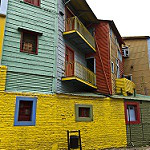

In [2]:
# opening image using open function of PIL package
image = Image.open('intel-image-classification/seg_train/seg_train/buildings/4.jpg')

# image size
print('The image size is:', image.size)

# Seeing the image
image

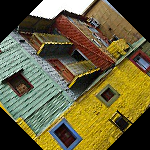

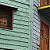

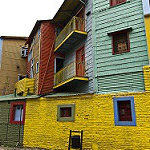

In [3]:

# rotating the image
imgRotated = image.rotate(45)
display(imgRotated)

# cropping the image
imgCrop = image.crop([25, 25, 75, 75])
display(imgCrop)


# flipping the image left to right
imgFlip = image.transpose(Image.FLIP_LEFT_RIGHT)
display(imgFlip)

The shape of the array is: (150, 150, 3)


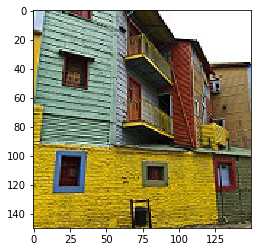

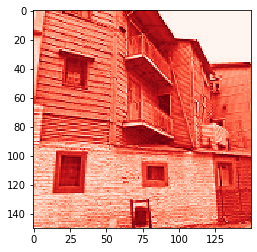

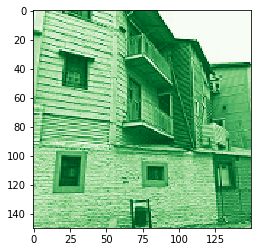

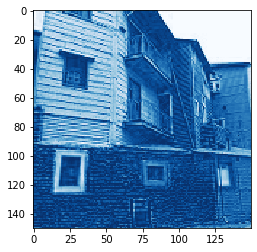

In [4]:
# turning the image into a numpy array 
imgData = np.array(image)

# checking the shape of the aaray
print('The shape of the array is:', imgData.shape)

# Plplottingot the data with imshow
plt.imshow(imgData)
plt.show()

# plotting the red channel 
plt.imshow(imgData[:,:,0], cmap=plt.cm.Reds_r)
plt.show()

# plotting the green channel
plt.imshow(imgData[:,:,1], cmap=plt.cm.Greens_r)
plt.show()

# plotting the blue channel
plt.imshow(imgData[:,:,2], cmap=plt.cm.Blues_r)
plt.show()

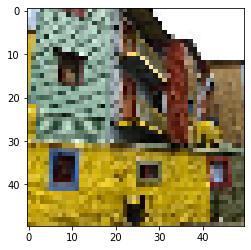

(50, 50, 3)

In [5]:
# resize the image for model
imgResize = np.array(image.resize((50,50)))
# plotting the data with imshow
plt.imshow(imgResize)
plt.show()

imgResize.shape

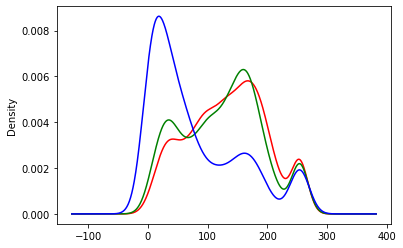

In [6]:
# plot the Kernel Density Estimate (kde)
def plotKDE(channel, color):
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# list of channels
channels = ['r', 'g', 'b']

def plotRGB(imageData):
    for i, color in enumerate(channels):
        plotKDE(imageData[:,:,i], color)
    plt.show()
    
plotRGB(imgResize)

forest


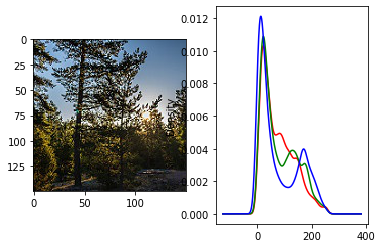

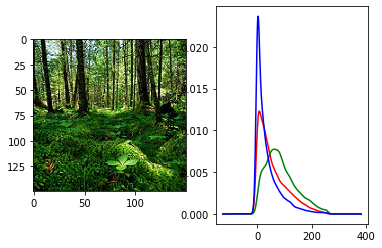

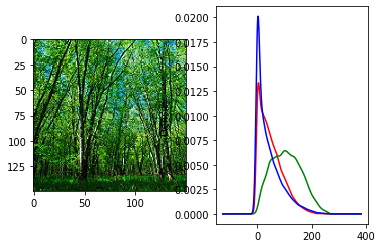

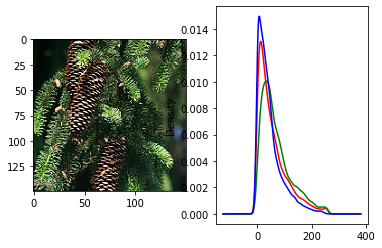

buildings


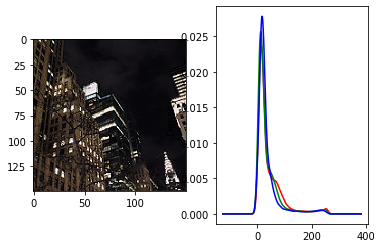

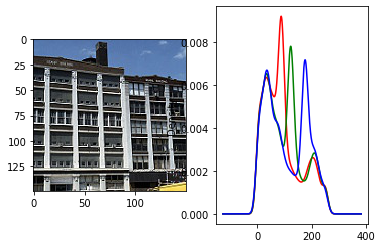

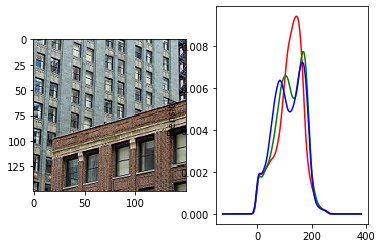

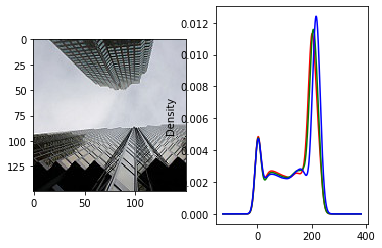

glacier


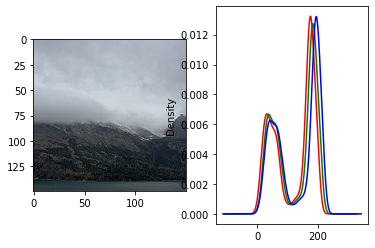

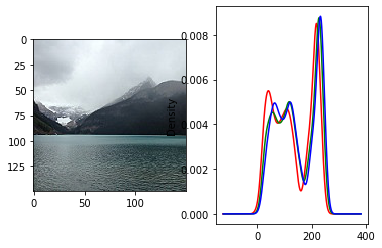

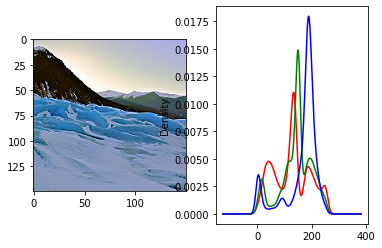

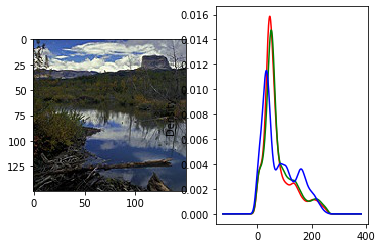

street


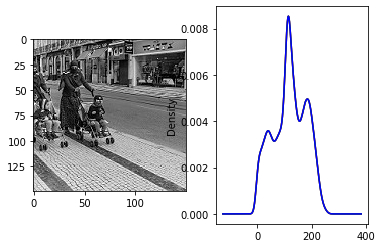

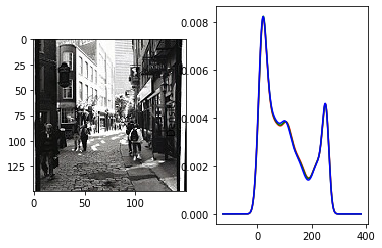

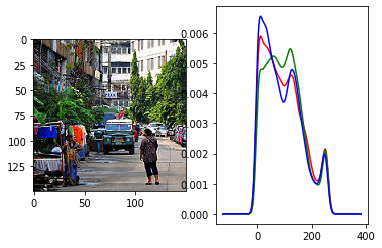

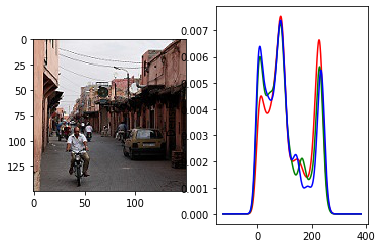

mountain


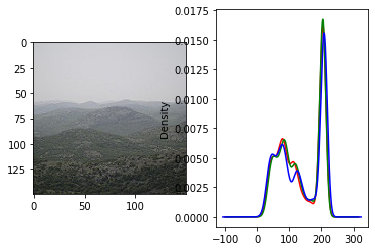

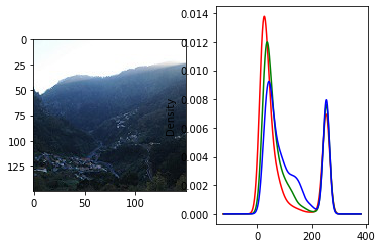

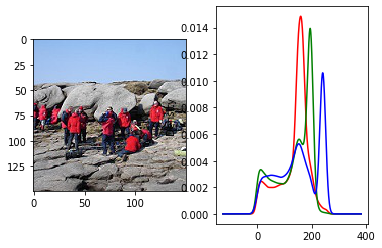

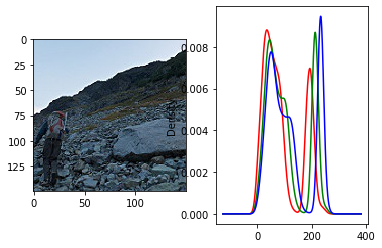

sea


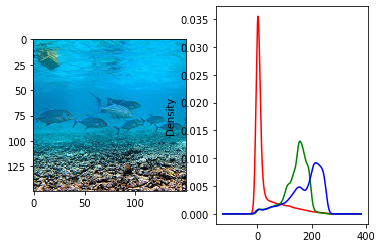

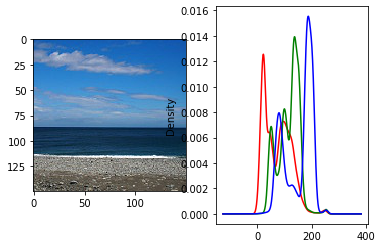

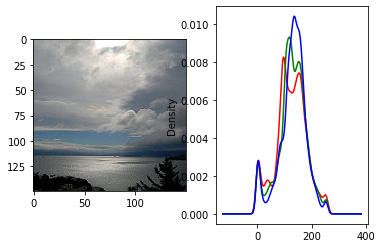

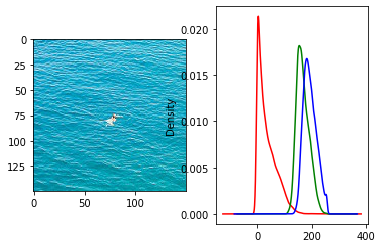

In [7]:
# printing 4 images with the KDE graph from the train folder

path = 'intel-image-classification/seg_train/seg_train'
for folder in os.listdir(path):
    print(folder)
    for file in os.listdir(Path(path, folder))[0:4]:
        img = Image.open(Path(path, folder, file))
        imageData = np.array(img.resize((150, 150)))
        plt.subplot(1, 2, 1).imshow(imageData)
        plt.subplot(1, 2, 2)
        plotRGB(imageData)

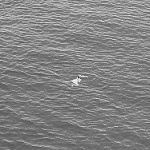

The shape of the array: (150, 150)


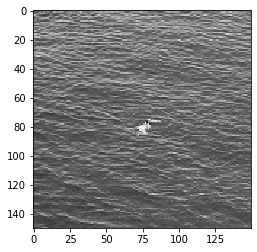

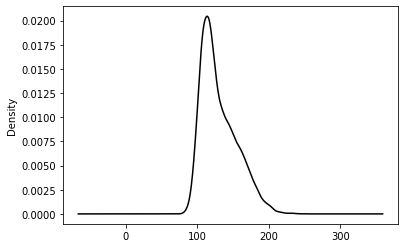

In [8]:
# converting image to grayscale
imgBW = img.convert('L')
display(imgBW)

# converting to the image to array
imgBWarr = np.array(imgBW.resize((150,150)))

# checking the shape
print('The shape of the array:', imgBWarr.shape)

# plotting the array using matplotlib
plt.imshow(imgBWarr, cmap=plt.cm.gray)
plt.show()

# checking plotKDE function by plotting kde of the new array
plotKDE(imgBWarr, 'k')

In [9]:
# defining labels as a dictionary
imageLabels = { 'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}

# defining labels as a dictionary (inverse)
imageLabelsInv = { 0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}

labels = []

# looping over images in the folder (image classification data)
for folder in os.listdir(path):
    for file in os.listdir(Path(path, folder)):
        img = Image.open(Path(path, folder, file))
        #if np.array(img).shape == (150, 150, 3): 
        labels.append([(int(os.path.splitext(file)[0])), imageLabels.get(folder)])
        
labels = pd.DataFrame(labels, columns=['id','label'])
labels = labels.set_index('id')
labels.head()

label
id          
5109       1
14621      1
6366       1
4565       1
17472      1

In [35]:
# converting an image id into the numpy array of the corresponding image
def getIMG(rowId):
    folder = imageLabelsInv.get(labels.loc[rowId, 'label'])
    filename = '{}.jpg'.format(rowId)
    filepath = Path(path, folder, filename)
    img = Image.open(filepath)
    return np.array(img.resize((150,150)))

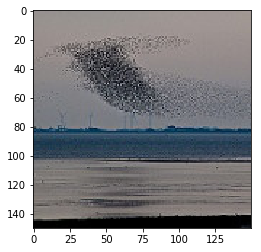

In [13]:
#  data from the tenth id in the sea images
seaID = labels[labels.label == 4].index[9]

plt.imshow(getIMG(seaID))
plt.show() 

In [14]:
# checking number of images per class
for i in range(6):
    print(i, labels[labels.label == i].size)

0 2191
1 2271
2 2404
3 2512
4 2274
5 2382


In [15]:
# sea image
sea = getIMG(seaID)

# shape of the sea image
print('The color image has shape: ', sea.shape)

# rgb2grey function to for converting the image to the greyscale
graySea = rgb2gray(sea)

# grey-scale image
plt.imshow(graySea, cmap=mpl.cm.gray)


# shape of grey image
print('The gray image has shape: ', graySea.shape)

The color image has shape:  (150, 150, 3)


NameError: name 'rgb2gray' is not defined

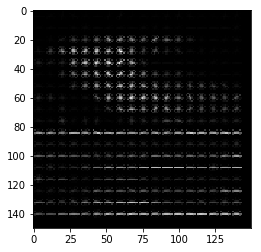

In [19]:
# using hog ( Histogram Over Gradient ) function to get the hog features of the grey image

hogFeatures, hogImage = hog(graySea, visualize=True, pixels_per_cell=(8,8), cells_per_block= (2,2))

# hog Image 
plt.imshow(hogImage, cmap=mpl.cm.gray)

In [33]:
def createFeatures(img):
    # flattening the colors of the image using img.flatten
    colorFeatures = img.flatten()
    
    # rgb2grey function to for converting the image to the greyscale
    grayImage = rgb2gray(img)
    
    # using hog function to get the hog features of the grey image
    hogFeatures = hog(grayImage, block_norm='L2-Hys', pixels_per_cell=(16,16))
    #combining the features
    flatFeatures = np.hstack((colorFeatures, hogFeatures))
    return flatFeatures
    
seaFeatures = createFeatures(sea)

# checking the shape of the matrix
print(seaFeatures.shape)

imageFeatures = seaFeatures

(71469,)


In [34]:
# function to create feature matrix
def createFM(df):
    featuresList = []
    
    for imgId in df.index:
        img = getIMG(imgId) #loading the image using our get image function
        # Get features for image
        imageFeatures = createFeatures(img).astype(np.float32)
        # Adding the features to the list
        featuresList.append(imageFeatures)

    # getting matrix from the list 
    featuresList = np.array(featuresList)
    return featuresList

# Testing the  function
featureMatrix = createFM(labels)

In [35]:
# checking shape of feature matrix
print('The shape of the feature matrix is:', featureMatrix.shape)



The shape of the feature matrix is: (14034, 71469)


In [36]:
# Initiating StandardScaler 
ss = StandardScaler()
# Apply the scaler
featureMtrix = ss.fit_transform(featureMatrix)

In [44]:
pca = PCA(n_components=7000)
# using fit_transform to run PCA on our standardized matrix
featureMatrix = pca.fit_transform(featureMatrix)
# look at new shape
print('PCA matrix shape is: ', featureMatrix.shape)

PCA matrix shape is:  (14034, 7000)


In [45]:
y = labels.label.values
# train test split distribution of data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(featureMatrix, y, test_size=.3)


# checking at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

3    1782
5    1709
2    1692
1    1572
4    1550
0    1518
dtype: int64

In [46]:
# defining the support vector classifier
svm = SVC(kernel='linear', probability=True)

# fitting the model with train data
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [47]:
# generating predictions using svm predict
yPred = svm.predict(X_test)

# calculating accuracy using accuracy_score from svc 
accuracy = accuracy_score(y_test, yPred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.4533364996437901


In [ ]:
classification_report(y_test, y_pred)

# Convulated Neural Network
Applying deep learning for classification

Using TensorFlow and Keras ( from TensorFlow 2.0 Package )


In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import os
import glob as gb
import cv2
import tensorflow as tf
#import keras
import tensorflow.keras as keras
from tensorflow.keras import backend

In [102]:
trainPath = 'intel-image-classification/seg_train/'
testPath = 'intel-image-classification/seg_test/'
predPath = 'intel-image-classification/seg_pred/'

In [103]:
#Checking the folder content (Train Folder)
for folder in  os.listdir(trainPath + 'seg_train') : 
    files = gb.glob(pathname= str( trainPath +'seg_train//' + folder + '/*.jpg'))
    print(f'For training data , found {len(files)} in folder {folder}')

For training data , found 2271 in folder forest
For training data , found 2191 in folder buildings
For training data , found 2404 in folder glacier
For training data , found 2382 in folder street
For training data , found 2512 in folder mountain
For training data , found 2274 in folder sea


In [104]:
#Checking the folder content for Test Folder
for folder in  os.listdir(testPath +'seg_test') : 
    files = gb.glob(pathname= str( testPath +'seg_test//' + folder + '/*.jpg'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For testing data , found 474 in folder forest
For testing data , found 437 in folder buildings
For testing data , found 553 in folder glacier
For testing data , found 501 in folder street
For testing data , found 525 in folder mountain
For testing data , found 510 in folder sea


In [105]:
#Prediction Folder
files = gb.glob(pathname= str(predPath +'seg_pred/*.jpg'))
print(f'For Prediction data , found {len(files)}')

For Prediction data , found 7301


In [106]:
#Checkinh the images

code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x    

In [107]:
#Checking the size of the images
def checkSize(tP,folder):
    size = []
    for folder1 in  os.listdir(tP +folder) : 
        files = gb.glob(pathname= str( tP +folder +'//' + folder1 + '/*.jpg'))
        for file in files: 
            image = plt.imread(file)
            size.append(image.shape)
    return pd.Series(size).value_counts()

In [108]:
#checking the size of trainFolder
checkSize(trainPath,'seg_train')

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(123, 150, 3)        2
(142, 150, 3)        2
(144, 150, 3)        2
(108, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(136, 150, 3)        2
(119, 150, 3)        1
(133, 150, 3)        1
(100, 150, 3)        1
(140, 150, 3)        1
(131, 150, 3)        1
(149, 150, 3)        1
(105, 150, 3)        1
(141, 150, 3)        1
(115, 150, 3)        1
(76, 150, 3)         1
(110, 150, 3)        1
(120, 150, 3)        1
(147, 150, 3)        1
(102, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(81, 150, 3)         1
(124, 150, 3)        1
(97, 150, 3)         1
dtype: int64

In [109]:
#Checking the size of testFolder
checkSize(testPath,'seg_test')

(150, 150, 3)    2993
(72, 150, 3)        1
(110, 150, 3)       1
(76, 150, 3)        1
(141, 150, 3)       1
(81, 150, 3)        1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

In [110]:
size = []
files = gb.glob(pathname= str(predPath +'seg_pred/*.jpg'))
for file in files: 
    image = plt.imread(file)
    size.append(image.shape)
pd.Series(size).value_counts()

(150, 150, 3)    7288
(100, 150, 3)       1
(124, 150, 3)       1
(133, 150, 3)       1
(139, 150, 3)       1
(112, 150, 3)       1
(129, 150, 3)       1
(374, 500, 3)       1
(144, 150, 3)       1
(108, 150, 3)       1
(126, 150, 3)       1
(143, 150, 3)       1
(149, 150, 3)       1
(131, 150, 3)       1
dtype: int64

In [111]:
#Reading the images
#size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training
s = 100
Xtrain = []
ytrain = []
for folder in  os.listdir(trainPath +'seg_train') : 
    files = gb.glob(pathname= str( trainPath +'seg_train//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        Xtrain.append(list(image_array))
        ytrain.append(code[folder])

In [112]:
#Items in training dataset
print(f'we have {len(Xtrain)} items in X-train')

we have 14034 items in X-train


In [122]:
#function to plot the images in the folder
def plotImages(arr):
    plt.figure(figsize=(20,20))
    for n , i in enumerate(list(np.random.randint(0,len(arr),36))) : 
        plt.subplot(6,6,n+1)
        plt.imshow(arr[i])   
        plt.axis('off')
        plt.title(getcode(arr[i]))
        


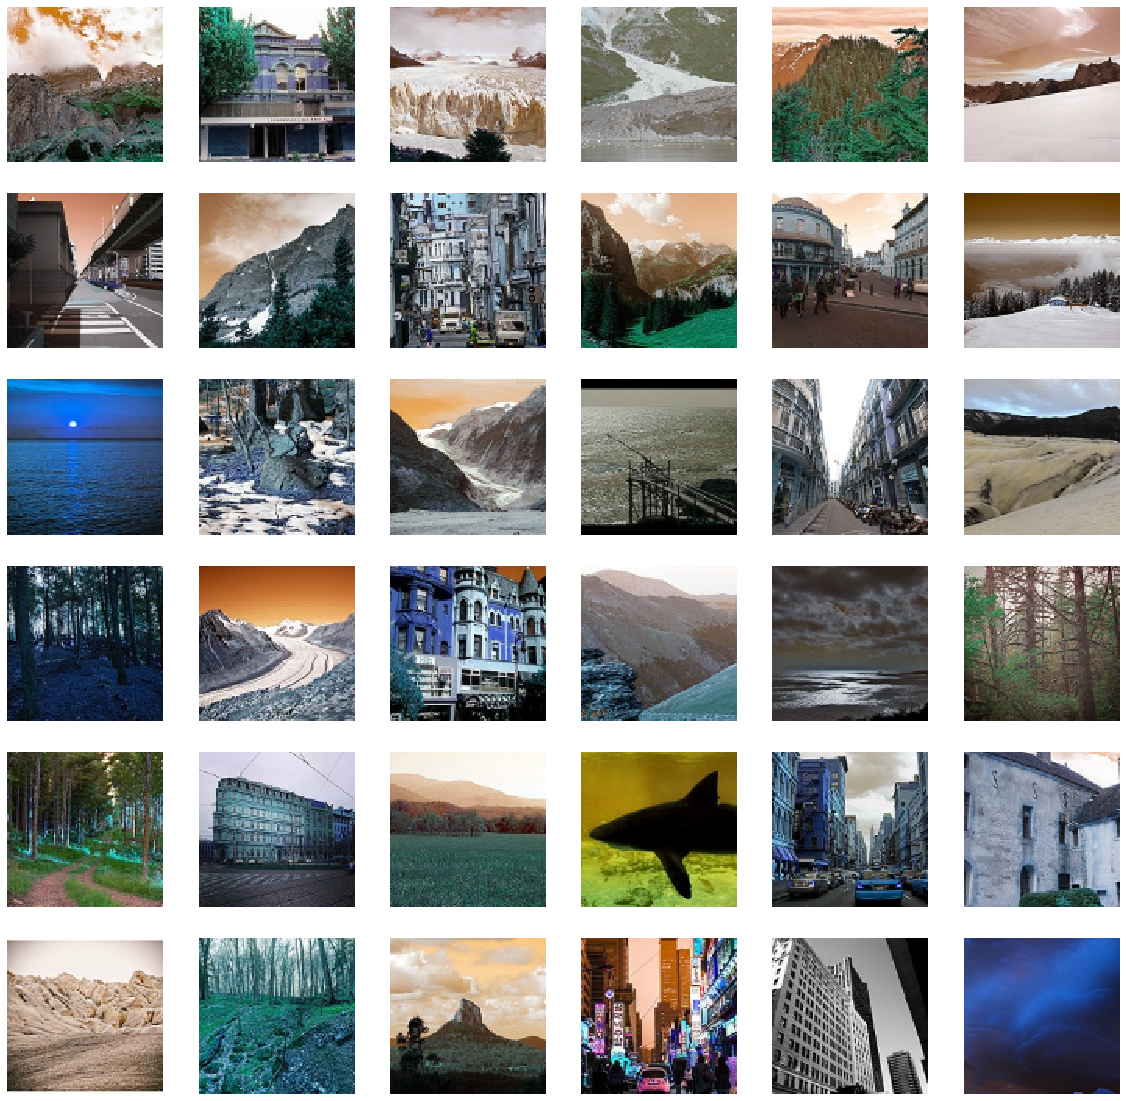

In [125]:
#we have have a look to random pictures in X_train , and to adjust their title using the y value

plotImages(Xtrain)

In [116]:
Xtest = []
ytest = []
for folder in  os.listdir(testPath +'seg_test') : 
    files = gb.glob(pathname= str(testPath + 'seg_test//' + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        Xtest.append(list(image_array))
        ytest.append(code[folder])
        

In [117]:
#Items in testing dataset
print(f'we have {len(Xtest)} items in X-Test')

we have 3000 items in X-Test


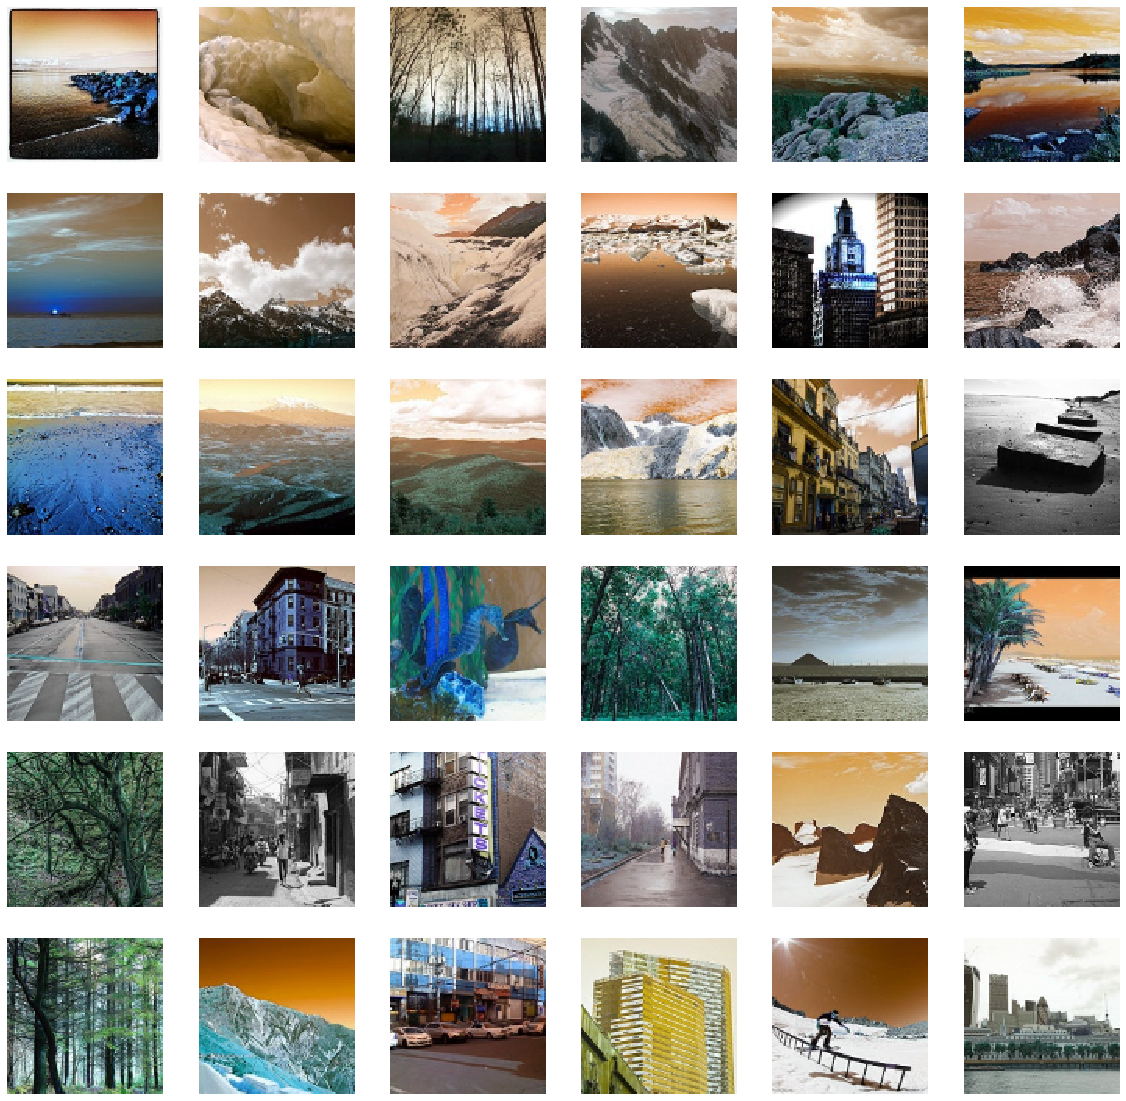

In [126]:
#Images in Xtest
plotImages(Xtest)

In [119]:
#with Prediction data , without having title ofcourse
Xpred = []
files = gb.glob(pathname= str(predPath + 'seg_pred/*.jpg'))
for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    Xpred.append(list(image_array))

In [97]:
print(f'we have {len(Xpred)} items in X-pred')

we have 7301 items in X-pred


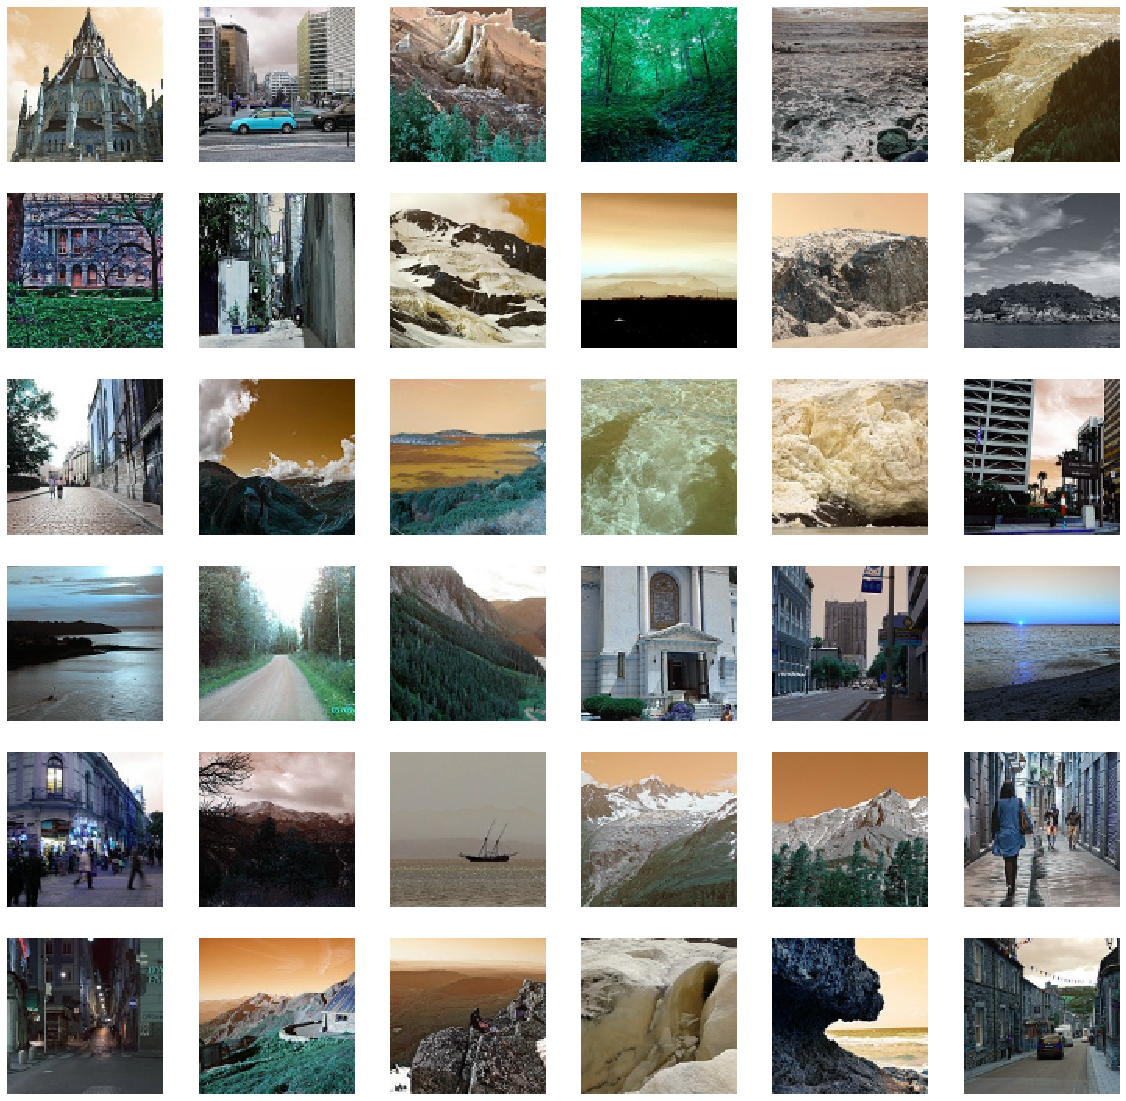

In [139]:
#images in Xpred 
plotImages(Xpred)

In [140]:
#The model
#first to convert the data into arrays using numpy


Xtrain = np.array(Xtrain)
Xtest = np.array(Xtest)
XpredArray = np.array(Xpred)
ytrain = np.array(ytrain)
ytest = np.array(ytest)

print(f'Xtrain shape  is {Xtrain.shape}')
print(f'Xtest shape  is {Xtest.shape}')
print(f'Xpred shape  is {XpredArray.shape}')
print(f'ytrain shape  is {ytrain.shape}')
print(f'ytest shape  is {ytest.shape}')

Xtrain shape  is (14034, 100, 100, 3)
Xtest shape  is (3000, 100, 100, 3)
Xpred shape  is (7301, 100, 100, 3)
ytrain shape  is (14034,)
ytest shape  is (3000,)


In [141]:

KerasModel = keras.models.Sequential([
        keras.layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        keras.layers.Conv2D(150,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Conv2D(120,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(80,kernel_size=(3,3),activation='relu'),    
        keras.layers.Conv2D(50,kernel_size=(3,3),activation='relu'),
        keras.layers.MaxPool2D(4,4),
        keras.layers.Flatten() ,    
        keras.layers.Dense(120,activation='relu') ,    
        keras.layers.Dense(100,activation='relu') ,    
        keras.layers.Dense(50,activation='relu') ,        
        keras.layers.Dropout(rate=0.5) ,            
        keras.layers.Dense(6,activation='softmax') ,    
        ])

Using Keras layers and models to manage variables

Keras models and layers offer the convenient variables and trainable_variables properties, which recursively gather up all dependent variables. This makes it easy to manage variables locally to where they are being used.

Sequential Model

In Keras, you assemble layers to build models. A model is (usually) a graph of layers. The most common type of model is a stack of layers: the tf.keras.Sequential model.

Layers

There are many tf.keras.layers available. Most of them share some common constructor arguments:
    
Dense:
Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).
    
Conv2D:
This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.
     
Dropout:
Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
     
MaxPool2D:
It provides Maximum pooling operation for spatial data.
     
Flatten:
It flattens the input. Does not affect the batch size.

Activation 

relu : Rectified Linear Unit

softmax : Softmax activation function
     
     

In [142]:
#Compiling the model using adam optimizer & sparse categorical crossentropy loss

KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Adam Optimizer
Adam, an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. The method is straightforward to implement, is computationally efficient, has little memory requirements, is invariant to diagonal rescaling of the gradients, and is well suited for problems that are large in terms of data and/or parameters. The method is also appropriate for non-stationary objectives and problems with very noisy and/or sparse gradients. The hyper-parameters have intuitive interpretations and typically require little tuning

Loss Calculation:
Sparse Categorical Crossentropy


In [143]:
#Model DEtails
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 200)       5600      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 150)       270150    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 150)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 22, 120)       162120    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 80)        86480     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 18, 50)        36050     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (Non

In [144]:
#Training the model using 50 epochs

e = 50
ThisModel = KerasModel.fit(Xtrain, ytrain, epochs=e,batch_size=64,verbose=1)

Train on 14034 samples
Epoch 1/50
14034/14034 [==============================] - 2511s 179ms/sample - loss: 1.9533 - accuracy: 0.3048
Epoch 2/50
14034/14034 [==============================] - 2544s 181ms/sample - loss: 1.2156 - accuracy: 0.5150
Epoch 3/50
14034/14034 [==============================] - 3272s 233ms/sample - loss: 1.0952 - accuracy: 0.5663
Epoch 4/50
14034/14034 [==============================] - 4372s 312ms/sample - loss: 0.9938 - accuracy: 0.6176
Epoch 5/50
14034/14034 [==============================] - 2601s 185ms/sample - loss: 0.9174 - accuracy: 0.6565
Epoch 6/50
14034/14034 [==============================] - 8649s 616ms/sample - loss: 0.8280 - accuracy: 0.7037
Epoch 7/50
14034/14034 [==============================] - 21202s 2s/sample - loss: 0.7626 - accuracy: 0.7295
Epoch 8/50
14034/14034 [==============================] - 7823s 557ms/sample - loss: 0.7145 - accuracy: 0.7544
Epoch 9/50
14034/14034 [==============================] - 7642s 545ms/sample - loss: 0.6751

KeyboardInterrupt: 

In [ ]:
#Model Evaluation ( Accuracy )

ModelLoss, ModelAccuracy = KerasModel.evaluate(Xtest, ytest)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

In [ ]:
#Predicting using Keras

yPred = KerasModel.predict(Xtest)

print('Prediction Shape is {}'.format(yPred.shape))

In [ ]:
yResult = KerasModel.predict(XpredArray)

print('Prediction Shape is {}'.format(yResult.shape))

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(Xpred),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(Xpred[i])    
    plt.axis('off')
    plt.title(getcode(np.argmax(yResult[i])))